# Correlation-based feature selection

This notebook takes the outptut of **centroid-sampling.pynb** and removes columns that are highly correlated (_>90%_)with other columns.

The process is as follows:

* identify the columns from each sub data set, e.g. fingerprints and binding-sites
* extract a subset, consiting of those columns from the centroid-sampled set (this limits cardinality)
* use the _Deepgraph_ code to  measure pairwise correlations across a random sample of 1,000 rows, across those columns. Retain the highly correlated column pairs.
* calculate pairwise correlation across all rows for the retained columns
* take one column from each remaining pair that are highly correlated
* remove all remaining highly-correlated columns from the data set and save back to file
<hr>

In [ ]:
%pylab inline
%autosave 25

from multiprocessing import Pool
from functools import partial

import pandas as pd
import deepgraph as dg
import os
import subprocess

## Data location

In [2]:
data_loc = '../data/FDA-COVID19_files_v1.0/'

## Load data set output from centroid-sampling.ipynb

In [3]:
store = pd.HDFStore(data_loc + 'sampled_data.h5')
df_features = pd.DataFrame(store['df' ])
store.close()
print('rows: {:,}, columns: {:,}'.format(len(df_features), len(df_features.columns)))

df_features.head()

rows: 22,172, columns: 16,391


,cid,pid,activity,AEK,VEL,EKF,LGM,VKN,LKP,NEE,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
58,204,Q99VQ4,1,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
97,204,EDT84149,0,3.936758,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
98,204,AAX80043,0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
126,204,P0C6X7,1,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,2.367871,...,0,0,0,0,0,0,0,0,0,0
136,8549,P08659,0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0


### Get column names associated with a data set

In [36]:
def get_col_names(file_name):
    df = pd.read_csv(data_loc+file_name, index_col=0, nrows=0) # We need only the column names
    df_cols = df.columns.tolist()
    
    # Take intersction with the most up to date, full feature set to drop those that have
    # already been eliminated, e.g. because of zero variance columns removed in centroid-sampling.ipynb.
    cols = df_features.columns.intersection(df_cols)
    del df
    del df_cols
    return cols

### Clean up old files

In [5]:
# delete old correlation files
def clean_up():
    subprocess.run('rm {}correlations/*'.format(data_loc), shell=True)

### Preprocess data

In [6]:
def pre_process(df_data):
    # whiten variables for fast parallel computation later on
    df_data = (df_data - df_data.mean(axis=1, keepdims=True)) / df_data.std(axis=1, keepdims=True)

    # save in binary format
    np.save(data_loc+'samples', df_data)

### Get data for subset of columns

In [89]:
def get_get_data(file_name, samples=None):
    clean_up()
    cols = get_col_names(file_name)
    
    if sample is None:
        X =  df_features[cols].values.T
    else:
        X =  df_features[cols].sample(n=samples, random_state=23).values.T
        
    pre_process(X)
    print('Data shape: {}.'.format(X.shape))
    del X
    
    # load samples as memory-map
    return (np.load(data_loc+'samples.npy', mmap_mode='r'), cols)

### Deepgraph parallel computation of Pearson's Correlation Coefficient

In [8]:
# connector function to compute pairwise pearson correlations
# index_s and index_t are equal length arrays of indices for pairwise correlation
def corr(index_s, index_t):
    features_s = X[index_s].T
    features_t = X[index_t].T
    
    c = 1./(n_samples - 1)
    cov_xy = c * np.dot(features_s.T, features_t)
    var_x = c * np.sum(features_s**2, axis=0)
    var_y = c * np.sum(features_t**2, axis=0)
    corrcoef_xy = cov_xy / np.sqrt(var_x[:, None] * var_y[None,:])
    corr = np.diag(corrcoef_xy)
    
    del cov_xy
    del var_x
    del var_y
    del corrcoef_xy
    
    #if 1947 in index_t:
    #    print('corrcoef_xy shape: {}, index_s shape: {}, index_t shape: {}'.format(corrcoef_xy.shape, index_s.shape, index_t.shape))
    
    return corr
    

# parallel computation
def create_ei(i):
    from_pos = pos_array[i]
    to_pos = pos_array[i+1]

    # initiate DeepGraph
    g = dg.DeepGraph(v)

    # create edges
    g.create_edges(connectors=corr, step_size=step_size,
                   from_pos=from_pos, to_pos=to_pos)

    # store edge table
    g.e.to_pickle((data_loc+'correlations/{}.pickle').format(str(i).zfill(3)))


# computation
def calculate_correlation():
    os.makedirs(data_loc+'correlations/', exist_ok=True)
    indices = np.arange(0, n_processes - 1)
    p = Pool()
    for _ in p.imap_unordered(create_ei, indices):
        pass

In [9]:
def retrieve_results():
    # store correlation values
    files = os.listdir(data_loc+'correlations/')
    files.sort()
    store = pd.HDFStore(data_loc+'e.h5', mode='w')
    for f in files:
        #print((data_loc+'correlations/{}').format(f))
        et = pd.read_pickle((data_loc+'correlations/{}').format(f))
        store.append('e', et, format='t', data_columns=True, index=False)
    store.close()
    
    # load correlation table
    e = pd.read_hdf(data_loc+'e.h5')
    
    return e

In [99]:
def get_cols_to_drop(df_corr, cols):
    pairs = list(df_corr.index)
    p2 = set([t for (s, t) in pairs])

    print('Dropping {:,} columns.'.format(len(p2)))

    cols_to_drop = [cols[i] for i in p2]
    return cols_to_drop

### Set of columns names to drop

In [100]:
drop_cols = []

### RAM control

In [10]:
step_size = 5e2
n_processes = 1500

### drug_features/fingerprints.csv

In [11]:
(X, cols) = get_get_data('drug_features/fingerprints.csv', samples=1000)

n_features = len(X)
n_samples = len(X[1])

# index array for parallelization
pos_array = np.array(np.linspace(0, n_features*(n_features-1)//2, n_processes), dtype=int)

# create node table that stores references to the mem-mapped samples
v = pd.DataFrame({'index': range(X.shape[0])})

calculate_correlation()
del v
del X

res = retrieve_results().abs()
finger_print_corr = res[res['corr'] > 0.9]
print('Number of highly correlated column pairs: {:,}'.format(len(finger_print_corr)))

drop_cols = drop_cols + get_cols_to_drop(finger_print_corr, cols)

Data shape: (4096, 1000).
Number of highly correlated column pairs: 2


### drug_features/dragon_features

In [19]:
(X, cols) = get_get_data('drug_features/dragon_features.csv', samples=1000)

n_features = len(X)
n_samples = len(X[1])

# index array for parallelization
pos_array = np.array(np.linspace(0, n_features*(n_features-1)//2, n_processes), dtype=int)

# create node table that stores references to the mem-mapped samples
v = pd.DataFrame({'index': range(X.shape[0])})

calculate_correlation()
del v
del X

res = retrieve_results().abs()
dragon_features_corr = res[res['corr'] > 0.9]
print('Number of highly correlated column pairs: {:,}'.format(len(dragon_features_corr)))

drop_cols = drop_cols + get_cols_to_drop(finger_print_corr, cols)

Data shape: (2972, 1000).


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Number of highly correlated column pairs: 57,306


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1d2aab518>]],
      dtype=object)

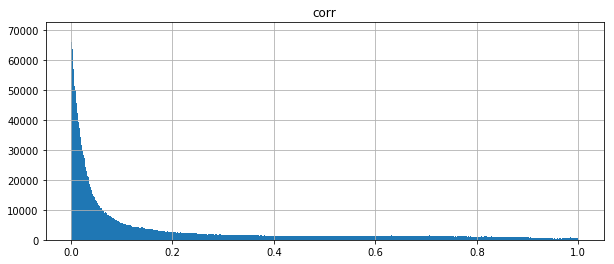

In [21]:
res.hist(bins=1000, figsize=(10,4))

### protein_features/binding_sites_v1.0.csv

In [22]:
(X, cols) = get_get_data('protein_features/binding_sites_v1.0.csv', samples=1000)

n_features = len(X)
n_samples = len(X[1])

# index array for parallelization
pos_array = np.array(np.linspace(0, n_features*(n_features-1)//2, n_processes), dtype=int)

# create node table that stores references to the mem-mapped samples
v = pd.DataFrame({'index': range(X.shape[0])})

calculate_correlation()
del v
del X

res = retrieve_results().abs()
binding_sites_corr = res[res['corr'] > 0.9]
print('Number of highly correlated column pairs: {:,}'.format(len(binding_sites_corr)))

drop_cols = drop_cols + get_cols_to_drop(finger_print_corr, cols)

Data shape: (8417, 1000).


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Number of highly correlated column pairs: 3,301


### protein_features/expasy.csv

In [41]:
# Can skip this given that there're hardly any columns in this data set

'''(X, cols) = get_get_data('protein_features/expasy.csv', samples=1000)

n_features = len(X)
n_samples = len(X[1])

# index array for parallelization
pos_array = np.array(np.linspace(0, n_features*(n_features-1)//2, n_processes), dtype=int)

# create node table that stores references to the mem-mapped samples
v = pd.DataFrame({'index': range(X.shape[0])})

calculate_correlation()
del v
del X

res = retrieve_results().abs()
expasy_corr = res[res['corr'] > 0.9]
print('Number of highly correlated column pairs: {:,}'.format(len(expasy_corr)))

drop_cols = drop_cols + get_cols_to_drop(finger_print_corr, cols)'''

"X = get_get_data('protein_features/expasy.csv', samples=1000)\n\nn_features = len(X)\nn_samples = len(X[1])\n\n# index array for parallelization\npos_array = np.array(np.linspace(0, n_features*(n_features-1)//2, n_processes), dtype=int)\n\n# create node table that stores references to the mem-mapped samples\nv = pd.DataFrame({'index': range(X.shape[0])})\n\ncalculate_correlation()\ndel v\ndel X\n\nres = retrieve_results().abs()\nexpasy_corr = res[res['corr'] > 0.9]\nprint('Number of highly correlated column pairs: {:,}'.format(len(expasy_corr)))"

### protein_features/profeat.csv

In [90]:
(X, cols) = get_get_data('protein_features/profeat.csv', samples=1000)

n_features = len(X)
n_samples = len(X[1])

# index array for parallelization
pos_array = np.array(np.linspace(0, n_features*(n_features-1)//2, n_processes), dtype=int)

# create node table that stores references to the mem-mapped samples
v = pd.DataFrame({'index': range(X.shape[0])})

calculate_correlation()
del v
del X

res = retrieve_results().abs()
profeat_corr = res[res['corr'] > 0.9]
print('Number of highly correlated column pairs: {:,}'.format(len(profeat_corr)))

drop_cols = drop_cols + get_cols_to_drop(finger_print_corr, cols)

Data shape: (849, 1000).
Number of highly correlated column pairs: 1,858


### protein_features/porter.csv

In [14]:
# Can skip this given that there're hardly any columns in this data set

'''(X, cols) = get_get_data('protein_features/porter.csv', samples=1000)

n_features = len(X)
n_samples = len(X[1])

# index array for parallelization
pos_array = np.array(np.linspace(0, n_features*(n_features-1)//2, n_processes), dtype=int)

# create node table that stores references to the mem-mapped samples
v = pd.DataFrame({'index': range(X.shape[0])})

calculate_correlation()
del v
del X

res = retrieve_results().abs()
porter_corr = res[res['corr'] > 0.9]
print('Number of highly correlated column pairs: {:,}'.format(len(porter_corr)))

drop_cols = drop_cols + get_cols_to_drop(finger_print_corr, cols)'''

"X = get_get_data('protein_features/porter.csv', samples=1000)\n\nn_features = len(X)\nn_samples = len(X[1])\n\n# index array for parallelization\npos_array = np.array(np.linspace(0, n_features*(n_features-1)//2, n_processes), dtype=int)\n\n# create node table that stores references to the mem-mapped samples\nv = pd.DataFrame({'index': range(X.shape[0])})\n\ncalculate_correlation()\ndel v\ndel X\n\nres = retrieve_results().abs()\nporter_corr = res[res['corr'] > 0.9]\nprint('Number of highly correlated column pairs: {:,}'.format(len(porter_corr)))"